In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATASET_DIR = "DatasetHAR"
ACTIVITIES = [0, 1, 2, 3, 4, 5, 6]
POSITION = "chest"

In [7]:
def fetch_motion_data():
    recordings = []
    docs = []

    for file in sorted(os.listdir(DATASET_DIR)):
        if not file.endswith(".csv"):
            continue

        df = pd.read_csv(os.path.join(DATASET_DIR, file))

        for activity in ACTIVITIES:
            df_act = df[df["label"] == activity].reset_index(drop=True)
            if len(df_act) == 0:
                continue

            recordings.append(df_act)
            docs.append({
                "activity": activity,
                "phone_position": POSITION,
                "recording_id": file
            })

    print(f"Total recordings found: {len(recordings)}")
    return recordings, docs

In [8]:
def apply_global_frame(df):
    df_out = df.copy()

    quat = df[[
        "q_x_chest",
        "q_y_chest",
        "q_z_chest",
        "q_w_chest"
    ]].to_numpy()

    quat /= (np.linalg.norm(quat, axis=1, keepdims=True) + 1e-9)
    rot = R.from_quat(quat)

    acc_local = df[[
        "a_x_chest",
        "a_y_chest",
        "a_z_chest"
    ]].to_numpy()

    acc_world = rot.apply(acc_local)
    acc_world[:, 2] -= 9.81 

    df_out["ax_g"] = acc_world[:, 0]
    df_out["ay_g"] = acc_world[:, 1]
    df_out["az_g"] = acc_world[:, 2]

    gyro_local = df[[
        "g_x_chest",
        "g_y_chest",
        "g_z_chest"
    ]].to_numpy()

    gyro_world = rot.apply(gyro_local)

    df_out["gx_g"] = gyro_world[:, 0]
    df_out["gy_g"] = gyro_world[:, 1]
    df_out["gz_g"] = gyro_world[:, 2]

    return df_out

In [11]:
def visualize_global_frame_recordings(recordings, docs, max_plots=10):
    plot_count = 0

    for df, doc in zip(recordings, docs):
        if plot_count >= max_plots:
            print(f"Reached visualization cap ({max_plots}). Stopping.")
            break

        df_gft = apply_global_frame(df)

        title = (
            f"Activity: {doc['activity']}, "
            f"Position: {doc['phone_position']}, "
            f"Recording: {doc['recording_id']}"
        )

        time = np.arange(len(df_gft))

        accel_mag = np.sqrt(
            df_gft["ax_g"]**2 +
            df_gft["ay_g"]**2 +
            df_gft["az_g"]**2
        )

        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Accelerometer (Global Frame)")
        plt.plot(time, df_gft["ax_g"], label="Accel X_g")
        plt.plot(time, df_gft["ay_g"], label="Accel Y_g")
        plt.plot(time, df_gft["az_g"], label="Accel Z_g")
        plt.plot(time, accel_mag, label="Accel Magnitude", linewidth=2)
        plt.xlabel("Sample")
        plt.ylabel("Acceleration (m/s²)")
        plt.ylim(-50, 50)
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.show()

        gyro_mag = np.sqrt(
            df_gft["gx_g"]**2 +
            df_gft["gy_g"]**2 +
            df_gft["gz_g"]**2
        )

        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Gyroscope (Global Frame)")
        plt.plot(time, df_gft["gx_g"], "--", label="Gyro X_g")
        plt.plot(time, df_gft["gy_g"], "--", label="Gyro Y_g")
        plt.plot(time, df_gft["gz_g"], "--", label="Gyro Z_g")
        plt.plot(time, gyro_mag, label="Gyro Magnitude", linewidth=2)
        plt.xlabel("Sample")
        plt.ylabel("Angular Velocity")
        plt.ylim(-400, 400)
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.show()

        plot_count += 1

Total recordings found: 402


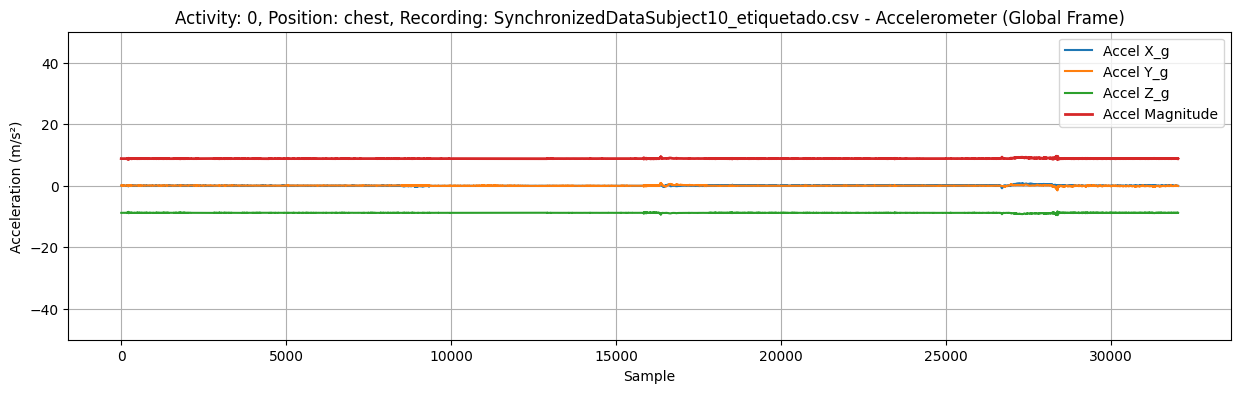

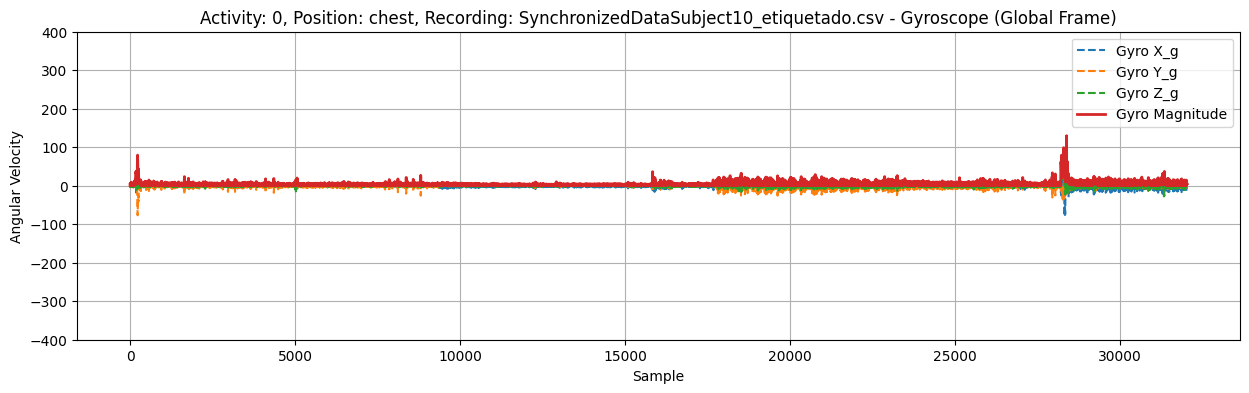

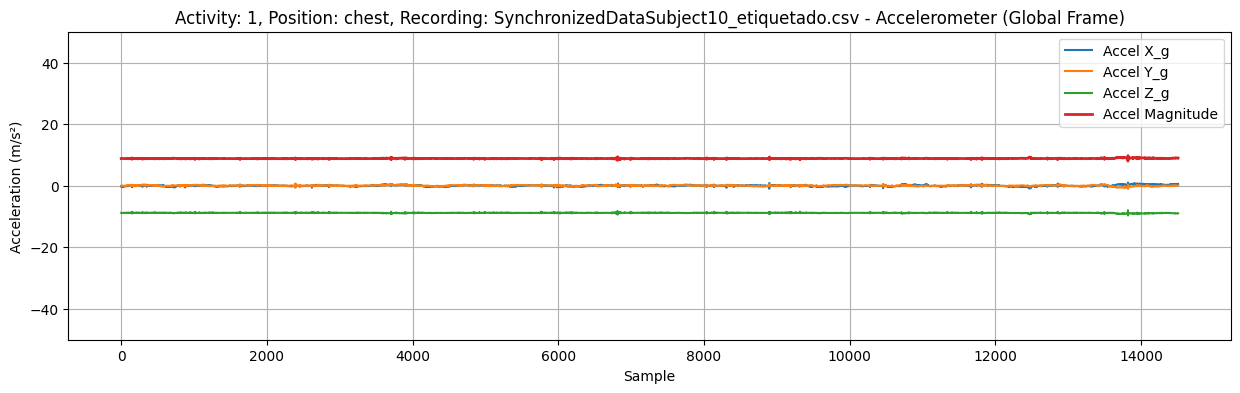

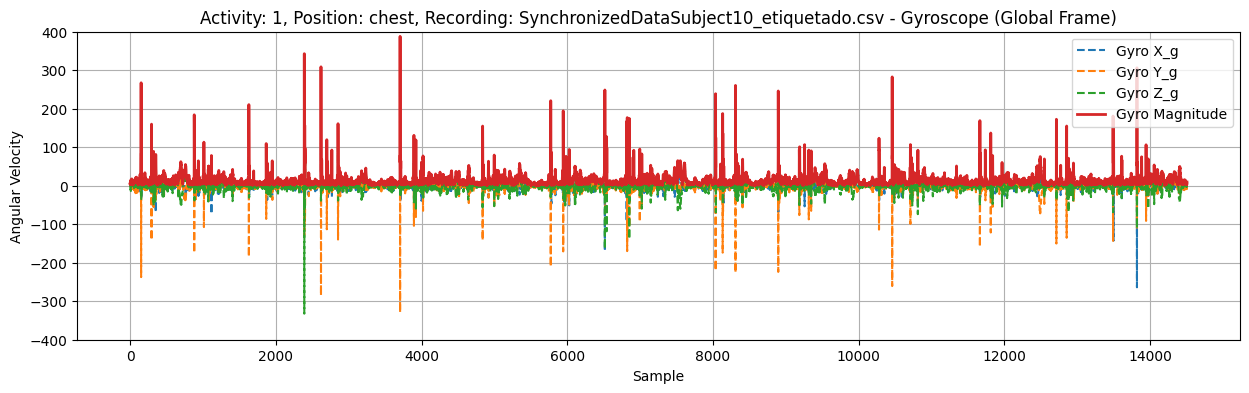

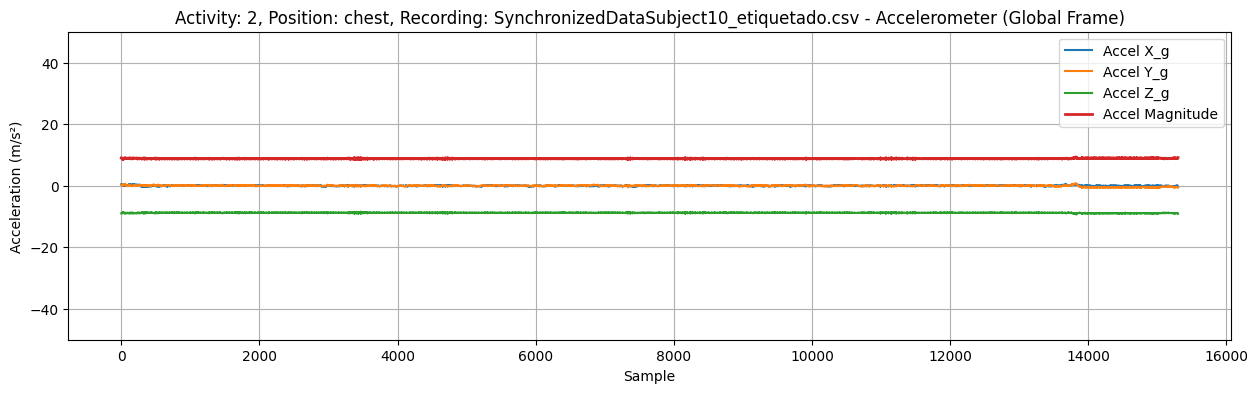

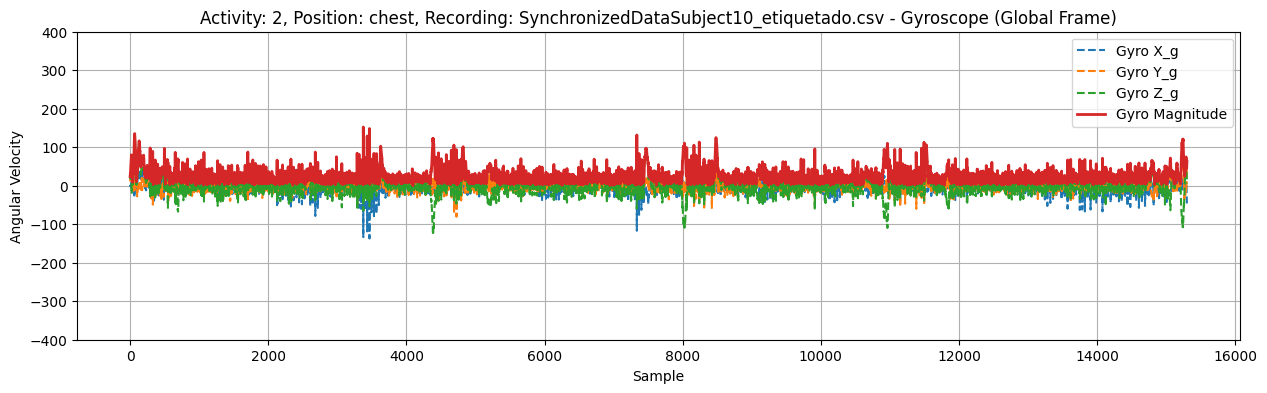

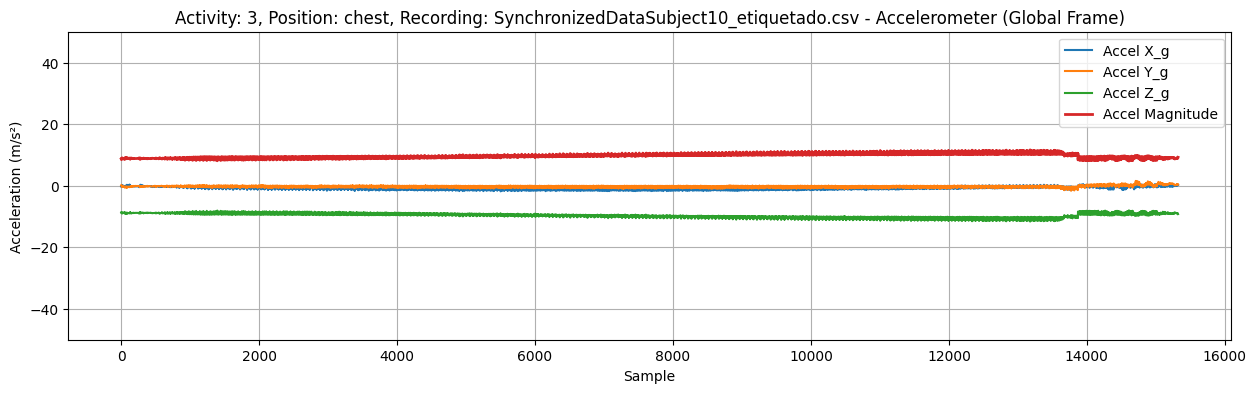

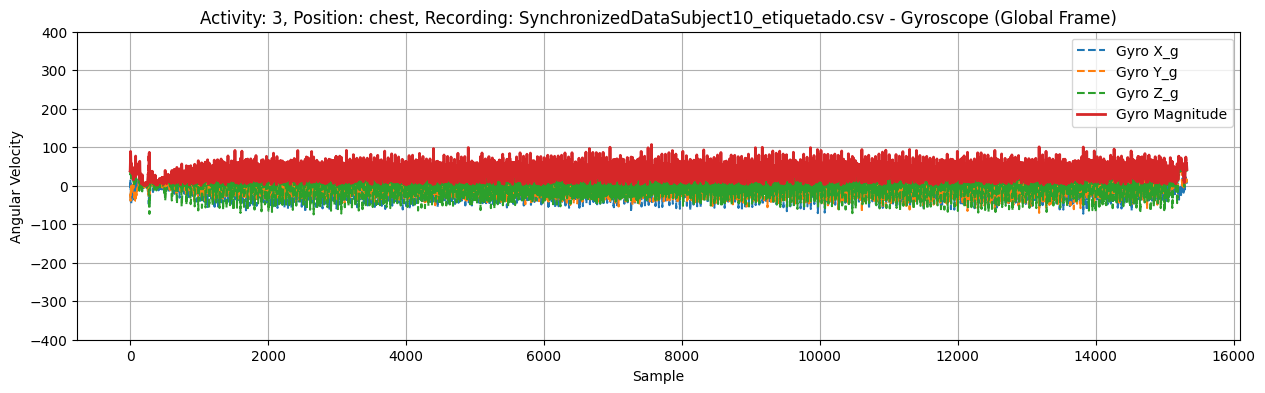

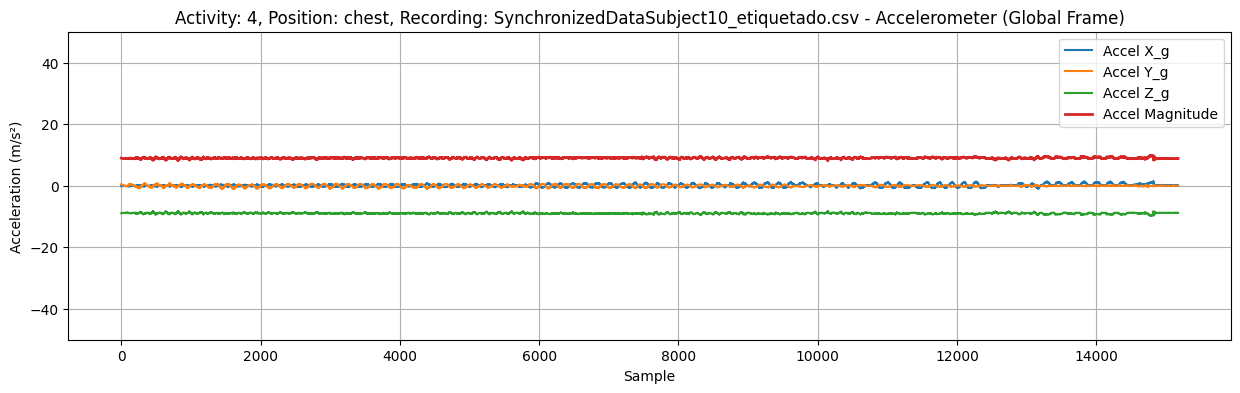

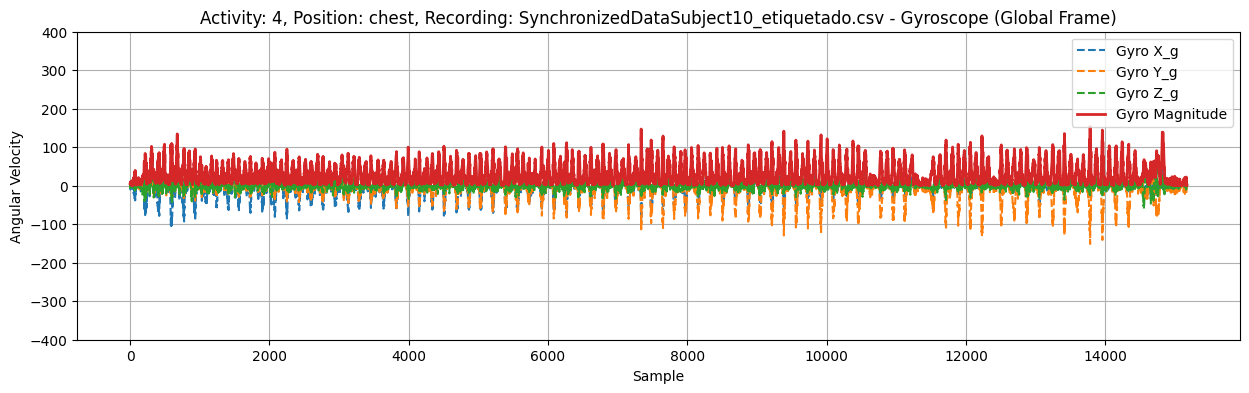

Reached visualization cap (5). Stopping.


In [13]:
if __name__ == "__main__":
    data, docs = fetch_motion_data()
    visualize_global_frame_recordings(data, docs, max_plots=5)